In [32]:
import numpy as np
import time
import matplotlib.pyplot as plt
from load_fmnist import TEXT_LABELS, load_images, load_labels
from softmax_reg import *

# Constantes
IN_DIM, OUT_DIM = 784, 10  # Dimension des images aplaties (28x28) et des classes
np.random.seed(42)         # Reproductibilité des résultats


In [33]:
## Chargement et préparation des données
# Chargement des données
train_imgs = load_images()
train_labels = load_labels()
val_imgs = load_images(test=True)
val_labels = load_labels(test=True)

# Vérifications des dimensions
assert train_imgs.shape == (60000, 28, 28)
assert train_labels.shape == (60000,)
assert val_imgs.shape == (10000, 28, 28)
assert val_labels.shape == (10000,)

# Aplatir les images
train_imgs_flat = train_imgs.reshape(len(train_imgs), -1)
val_imgs_flat = val_imgs.reshape(len(val_imgs), -1)
assert train_imgs_flat.shape == (60000, 784)
assert val_imgs_flat.shape == (10000, 784)

print("Data successfully loaded.")


Data successfully loaded.


In [34]:
## Fonctions principales : softmax, perte et gradient
def softmax_batch(o):
    """
    Calcul vectorisé de la fonction softmax pour un batch.
    """
    o_exp = np.exp(o - np.max(o, axis=1, keepdims=True))  # Stabilité numérique
    return o_exp / np.sum(o_exp, axis=1, keepdims=True)


def cross_entropy_loss_batch(probs, labels):
    """
    Calcul vectorisé de la perte d'entropie croisée pour un batch.
    """
    return -np.mean(np.log(probs[np.arange(len(labels)), labels] + 1e-15))


def grad_batch(batch_imgs, probs, labels):
    """
    Calcul vectorisé des gradients pour les poids et les biais.
    """
    probs[np.arange(len(labels)), labels] -= 1
    grad_W = batch_imgs.T @ probs / len(labels)
    grad_b = np.sum(probs, axis=0) / len(labels)
    return grad_W, grad_b


In [35]:
## Initialisation des poids et biais
def initialize(sigma=0.01):
    """
    Initialise les poids et biais avec des valeurs aléatoires.
    """
    W = np.random.normal(0, sigma, (IN_DIM, OUT_DIM))
    b = np.zeros(OUT_DIM)
    return W, b


In [36]:
## Fonction d'évaluation vectorisée
def evaluate_vec(W, b, ims, ys):
    """
    Évalue la précision du modèle sur un dataset donné, en mode vectorisé.
    """
    logits = ims @ W + b
    predictions = np.argmax(softmax_batch(logits), axis=1)
    return np.mean(predictions == ys)


In [37]:
## Entraînement vectorisé
def train_sgd_vec(lr=0.01, num_epochs=10, sigma=0.01, batch_size=64, W=None, b=None):
    """
    Entraîne un modèle de régression softmax avec SGD vectorisé.
    """
    print(f"Training with vectorized SGD, lr={lr}, batch_size={batch_size}, num_epochs={num_epochs}")

    if W is None: 
        W, b = initialize(sigma=sigma)

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        t0 = time.time()
        train_loss = 0

        # Boucle sur les batchs
        for batch_imgs, batch_labels in create_batches(train_imgs_flat, train_labels, batch_size):
            logits = batch_imgs @ W + b
            probs = softmax_batch(logits)
            train_loss += cross_entropy_loss_batch(probs, batch_labels)
            grad_W, grad_b = grad_batch(batch_imgs, probs, batch_labels)
            W -= lr * grad_W
            b -= lr * grad_b

        # Calcul des pertes et précisions
        val_logits = val_imgs_flat @ W + b
        val_probs = softmax_batch(val_logits)
        val_loss = cross_entropy_loss_batch(val_probs, val_labels)
        val_accuracy = evaluate_vec(W, b, val_imgs_flat, val_labels)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2%}, Time: {time.time() - t0:.2f}s")

    return W, b, train_losses, val_losses, val_accuracies


In [38]:
## Génération des batchs
def create_batches(data, labels, batch_size):
    """
    Génère des batchs aléatoires pour l'entraînement.
    """
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    N = len(indices)
    indices = indices[:(N // batch_size) * batch_size]  # Assurer un nombre divisible par la taille du batch
    for s in range(0, len(indices), batch_size):
        batch_indices = indices[s:s + batch_size]
        yield data[batch_indices], labels[batch_indices]


In [39]:
## Exécution de l'entraînement
# Entraîner le modèle
W_vec, b_vec, train_losses, val_losses, val_accuracies = train_sgd_vec(lr=0.01, num_epochs=10, batch_size=64)

# Évaluer la précision finale sur le dataset de validation
final_accuracy = evaluate_vec(W_vec, b_vec, val_imgs_flat, val_labels)
print(f"Final Validation Accuracy: {final_accuracy:.2%}")


Training with vectorized SGD, lr=0.01, batch_size=64, num_epochs=10
Epoch 1/10, Train Loss: 901.8800, Val Loss: 0.7392, Val Accuracy: 75.83%, Time: 0.25s
Epoch 2/10, Train Loss: 626.3845, Val Loss: 0.6480, Val Accuracy: 78.56%, Time: 0.28s
Epoch 3/10, Train Loss: 565.7353, Val Loss: 0.6047, Val Accuracy: 80.03%, Time: 0.25s
Epoch 4/10, Train Loss: 532.8893, Val Loss: 0.5810, Val Accuracy: 80.76%, Time: 0.28s
Epoch 5/10, Train Loss: 511.5515, Val Loss: 0.5611, Val Accuracy: 81.09%, Time: 0.31s
Epoch 6/10, Train Loss: 495.7676, Val Loss: 0.5489, Val Accuracy: 81.54%, Time: 0.27s
Epoch 7/10, Train Loss: 484.1627, Val Loss: 0.5369, Val Accuracy: 81.89%, Time: 0.24s
Epoch 8/10, Train Loss: 474.4444, Val Loss: 0.5290, Val Accuracy: 82.07%, Time: 0.28s
Epoch 9/10, Train Loss: 466.5516, Val Loss: 0.5213, Val Accuracy: 82.31%, Time: 0.25s
Epoch 10/10, Train Loss: 459.8180, Val Loss: 0.5169, Val Accuracy: 82.42%, Time: 0.28s
Final Validation Accuracy: 82.42%


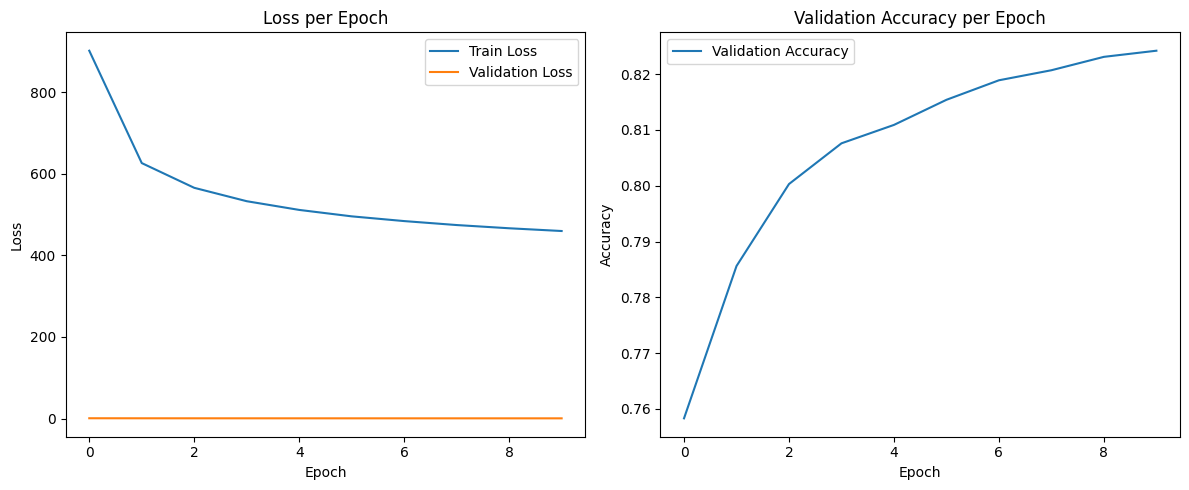

In [40]:
## Affichage des courbes de perte et de précision
# Afficher les courbes des pertes et précisions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [44]:
## Visualisation d'une image
# Afficher une image et son étiquette
# Chargement des données
train_imgs = load_images()
train_labels = load_labels()
show(0)  # Changez l'index pour voir d'autres exemples
